## Titanic Problem w Ensembles

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from collections import Counter
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

### Import Data

In [3]:
train = pd.read_csv('dataset/titanic/train.csv')
test = pd.read_csv('dataset/titanic/test.csv')

In [4]:
idtest = test['PassengerId']

### Outlier detection : https://www.youtube.com/watch?v=9aDHbRb4Bf8&t=10s

In [5]:
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over dataframe
    for col in features:

        # Find 1st Quartile
        Q1 = np.percentile(df[col],25)

        # Find 3rd Quartile
        Q3 = np.percentile(df[col],75)

        # Find InterQuartile Range
        IQR = Q3 - Q1

        # Setting outlier step to 1.5
        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # appending indices
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    
    multiple_outliers = list(k for k,v in outlier_indices.items() if v>n)

    return multiple_outliers

outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])

In [6]:
outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

### Counter Object

In [7]:
z=['blue','green','red','green','red','green','blue']
cntZ = Counter(z)

cntZ

Counter({'blue': 2, 'green': 3, 'red': 2})

In [8]:
list(k for k,v in cntZ.items() if v>2)

['green']

In [9]:
train.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


#### If we see outliers are having either high fare or high SibSp value

In [10]:
train = train.drop(outliers_to_drop,axis=0).reset_index(drop=True)

In [11]:
train.shape

(881, 12)

### Feature Engineering

In [12]:
train_len = len(train)

df = pd.concat(objs=[train,test],axis=0).reset_index(drop=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 12 columns):
Age            1043 non-null float64
Cabin          292 non-null object
Embarked       1297 non-null object
Fare           1298 non-null float64
Name           1299 non-null object
Parch          1299 non-null int64
PassengerId    1299 non-null int64
Pclass         1299 non-null int64
Sex            1299 non-null object
SibSp          1299 non-null int64
Survived       881 non-null float64
Ticket         1299 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 121.9+ KB


#### Check for missing values

In [14]:
df.fillna(np.nan, inplace=True)

df.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

#### Feature Analysis

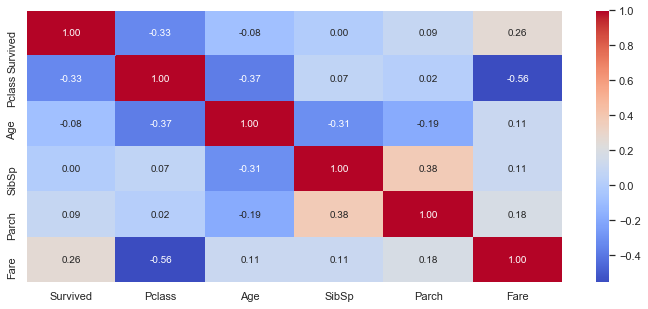

In [15]:
plt.figure(figsize=(12,5))

sns.heatmap(train[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].corr(),
           annot=True,
           cmap='coolwarm',
           fmt='.2f');

1. Fare is having correlation w Pclass and Survived


2. Pclass is having correlation w Fare and Survived and Age


3. SibSp and Parch are highly correlated

### Exploring SibSp

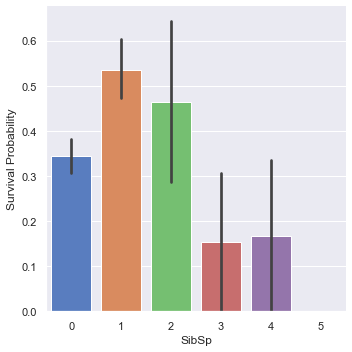

In [16]:
g = sns.factorplot(x='SibSp',y='Survived',data=train,kind='bar',palette='muted')
g = g.set_ylabels('Survival Probability')

1. More SibSp less survival


2. Single passengers and SibSp = 1,2 survived more than SibSp > 2

#### Parch

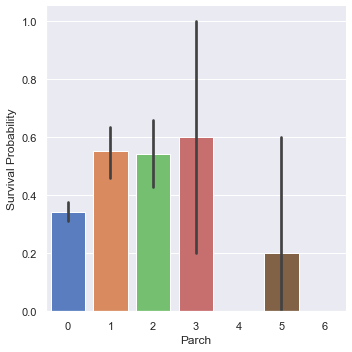

In [17]:
g = sns.factorplot(x='Parch',y='Survived',data=train,kind='bar',palette='muted')
g = g.set_ylabels('Survival Probability')

1. Smaller families have higher chance of survival.


* Single (0)

* Small (1,2)

* Medium (3,4)

* Large (5,6)

#### Age

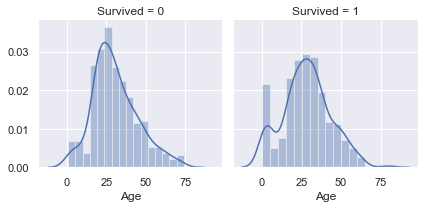

In [18]:
g = sns.FacetGrid(train,col='Survived')

g = g.map(sns.distplot,'Age')

1. Age distribution is of gaussian nature


2. Peak is indicating that younger population survived much more than older population.

#### Fare

In [19]:
df['Fare'].isnull().sum()

1

In [20]:
df['Fare'].fillna(df['Fare'].median(),inplace=True)

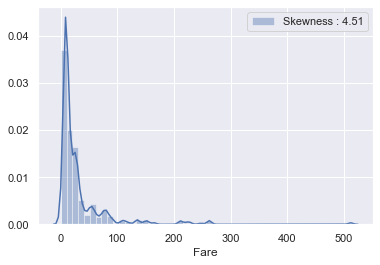

In [21]:
# Exploring fare distribution

g = sns.distplot(df['Fare'],label='Skewness : %.2f'%(df['Fare'].skew()))

g = g.legend()

##### Let's do a log transformation to reduce the skew

In [22]:
df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x>0 else 0)

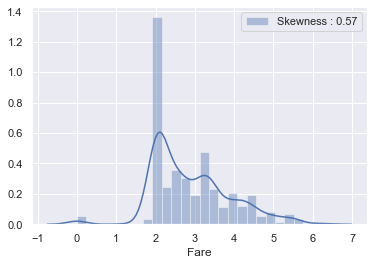

In [23]:
# Exploring fare distribution

g = sns.distplot(df['Fare'],label='Skewness : %.2f'%(df['Fare'].skew()))

g = g.legend()

##### Let's take a look at the categorical columns

#### Sex

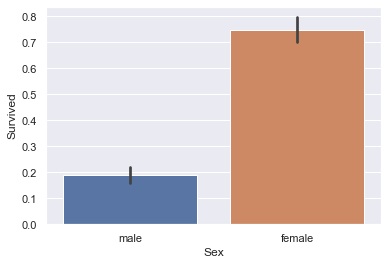

In [24]:
g = sns.barplot(x='Sex',y='Survived',data=train)

In [25]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


#### PClass

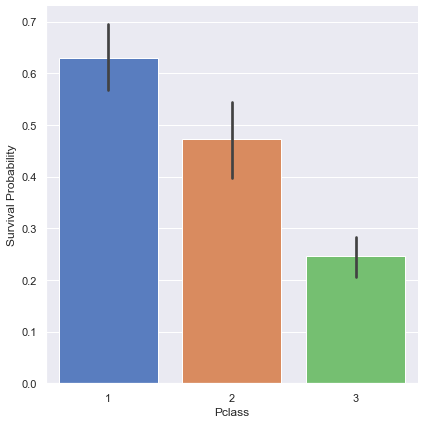

In [26]:
g = sns.factorplot(x='Pclass',y='Survived',data=train,kind='bar',palette='muted',size=6)

g = g.set_ylabels('Survival Probability')

Survival Prob (PClass=1) > Survival Prob (PClass=2) > Survival Prob (PClass=3)

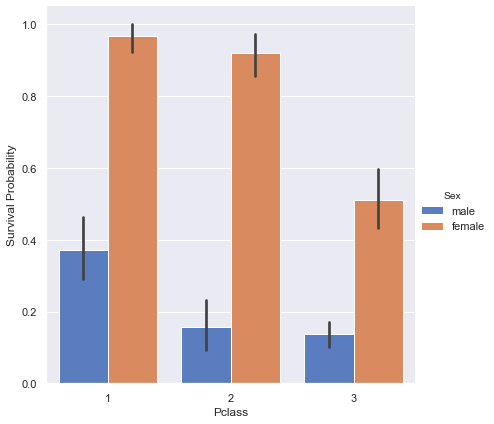

In [27]:
g = sns.factorplot(x='Pclass',y='Survived',data=train,kind='bar',palette='muted',size=6,hue='Sex')

g = g.set_ylabels('Survival Probability')

Trend by Sex ratio remains same.

#### Embarked

In [28]:
df['Embarked'].isnull().sum()

2

In [29]:
df['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

S = Southampton


C = Cherbourg


Q = Queenstown

In [30]:
df['Embarked'].fillna('S',inplace=True)

In [31]:
df['Embarked'].isnull().sum()

0

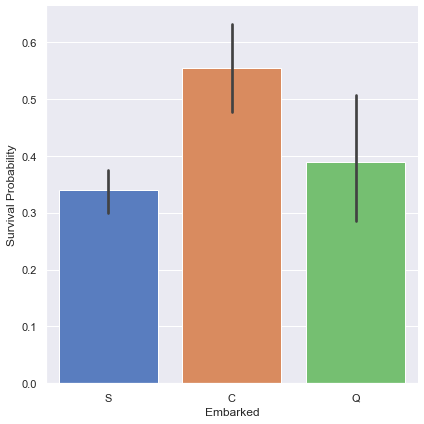

In [32]:
g = sns.factorplot(x = 'Embarked',
                   y = 'Survived',
                   data = train,
                   kind = 'bar',
                   size = 6,
                   palette = 'muted')

g = g.set_ylabels('Survival Probability')

1. Highest survival of passengers who embarked from C 

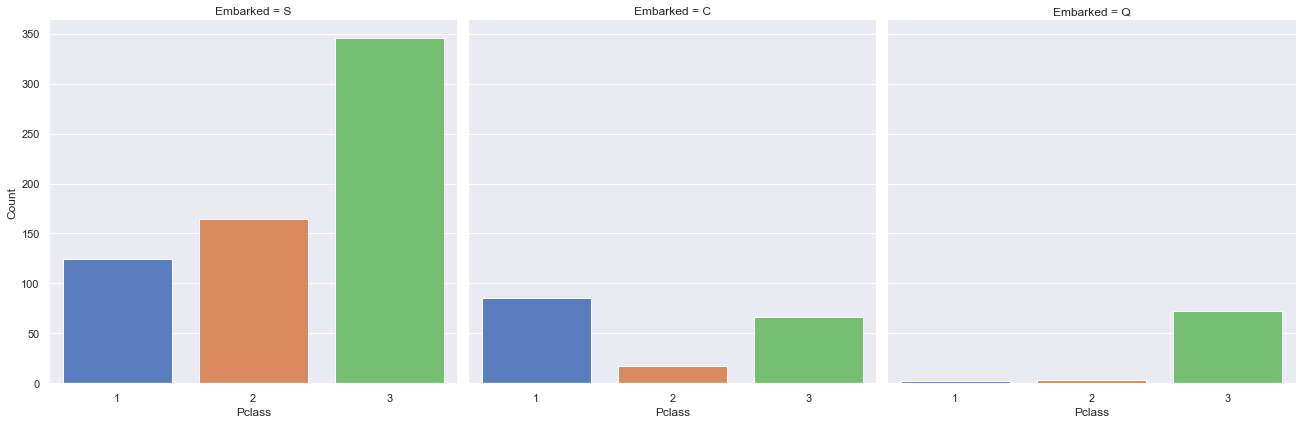

In [33]:
g = sns.factorplot(x = 'Pclass',
                   col = 'Embarked',
                   data = train,
                   kind = 'count',
                   size = 6,
                   palette = 'muted')

g = g.set_ylabels('Count')

#### Missing value imputations

In [34]:
df.isnull().sum()

Age             256
Cabin          1007
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [35]:
df.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket'],
      dtype='object')

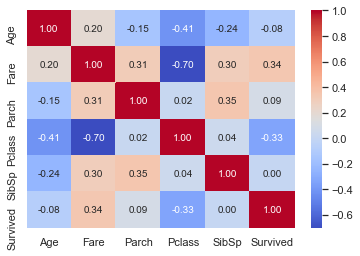

In [36]:
sns.heatmap(df[['Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived']].corr(),
           annot=True,
           fmt='.2f',
           cmap='coolwarm')

#### Imputing Age - 256 missing values

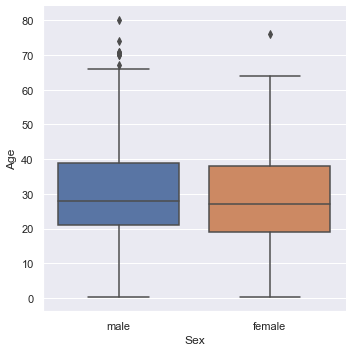

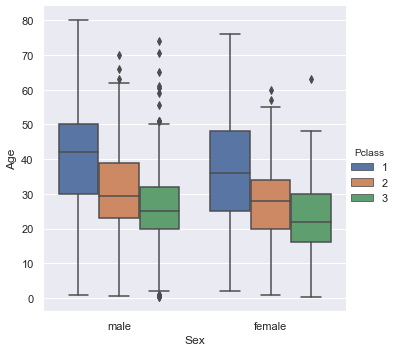

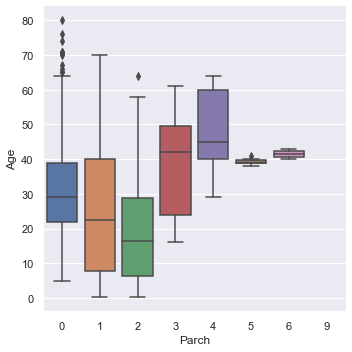

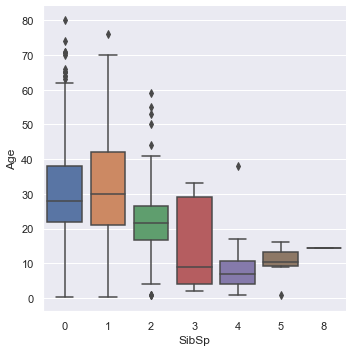

In [37]:
g = sns.factorplot(y='Age',x='Sex',data=df,kind='box')
g = sns.factorplot(y='Age',x='Sex',hue='Pclass',data=df,kind='box')
g = sns.factorplot(y='Age',x='Parch',data=df,kind='box')
g = sns.factorplot(y='Age',x='SibSp',data=df,kind='box')

In [38]:
df['Sex'].value_counts()

male      838
female    461
Name: Sex, dtype: int64

age_pred = df['Age'][(df['SibSp'] == 0) 
                        & (df['Parch'] == 0)
                        & (df['Pclass'] == 3].median()
    

df.iloc[5]['Pclass']

df.iloc[5]['Parch']

df.iloc[5]['SibSp']

In [39]:
## use SibSp, Parch, and Pclass

index_nan = list(df['Age'][df['Age'].isnull()].index)

age_median = df['Age'].median()

for i in index_nan:
    
    age_pred = df['Age'][(df['SibSp'] == df.iloc[i]['SibSp']) 
                        & (df['Parch'] == df.iloc[i]['Parch'])
                        & (df['Pclass'] == df.iloc[i]['Pclass'])].median()
    
    #print(f'index >>> {i} >>> age_pred >>>> {age_pred}')

    if not np.isnan(age_pred):
        df['Age'].iloc[i] = age_pred
    else:
        df['Age'].iloc[i] = age_median

In [40]:
df['Age'].isnull().sum()

0

#### Name

In [41]:
df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [42]:
s = 'Uruchurtu, Don. Manuel E'


df['Title'] = [s.split('.')[0].split(',')[1].strip() for s in df['Name']]

df['Title'].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Dr                8
Rev               8
Col               4
Ms                2
Mlle              2
Major             2
Dona              1
Don               1
Sir               1
the Countess      1
Capt              1
Lady              1
Jonkheer          1
Mme               1
Name: Title, dtype: int64

### Rare label imputation

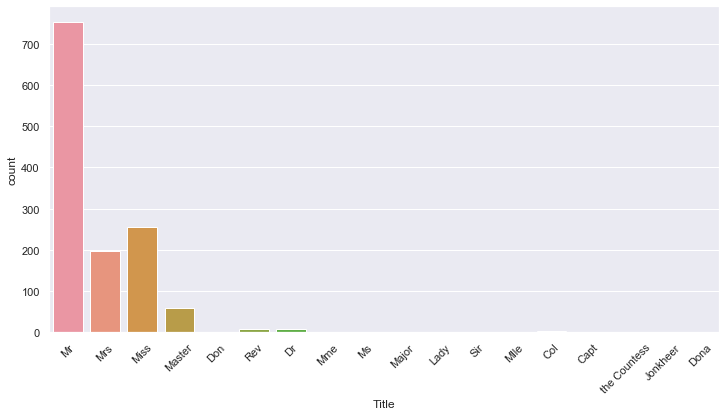

In [43]:
plt.figure(figsize=(12,6))
g = sns.countplot(x='Title',data=df)

g = plt.setp(g.get_xticklabels(),rotation=45)

In [44]:
df['Title'] = df['Title'].replace(['Don', 'Rev', 'Dr', 'Mme',
                                   'Major', 'Lady', 'Sir', 'Mlle', 'Col', 
                                   'Capt', 'the Countess',
                                   'Jonkheer', 'Dona'],'Rare')

df['Title'] = df['Title'].map({'Mr':0,'Mrs':1,'Miss':1, 'Ms':2 ,'Master':2,'Rare':3})

In [45]:
df['Title'].unique()

array([0, 1, 2, 3])

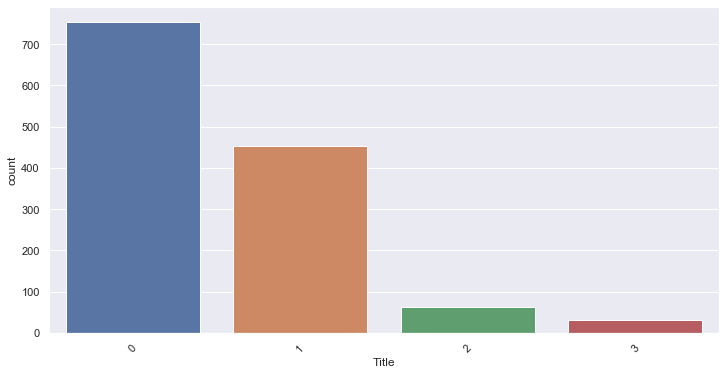

In [46]:
plt.figure(figsize=(12,6))
g = sns.countplot(x='Title',data=df)

g = plt.setp(g.get_xticklabels(),rotation=45)

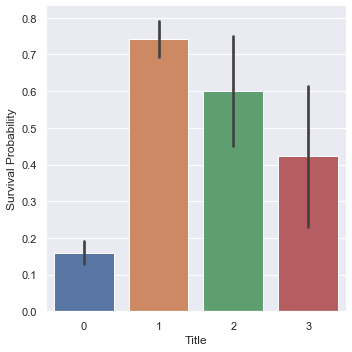

In [47]:
g = sns.factorplot(y='Survived',x='Title',data=df,kind='bar')

g = g.set_ylabels('Survival Probability')

P-Surv. (1) > (2) > (3) > (0)

In [48]:
df.drop('Name',axis=1,inplace=True)

#### Family Size

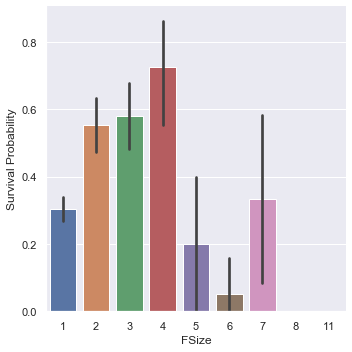

In [49]:
df['FSize'] = df['SibSp'] + df['Parch'] + 1

g = sns.factorplot(y='Survived',x='FSize',data=df,kind='bar')

g = g.set_ylabels('Survival Probability')

In [50]:
df['Single'] = df['FSize'].map(lambda x: 1 if x==1 else 0)
df['SmallF'] = df['FSize'].map(lambda x: 1 if x==2 else 0)
df['MediumF'] = df['FSize'].map(lambda x: 1 if 3 <= x <= 4 else 0)
df['LargeF'] = df['FSize'].map(lambda x: 1 if x > 4 else 0)

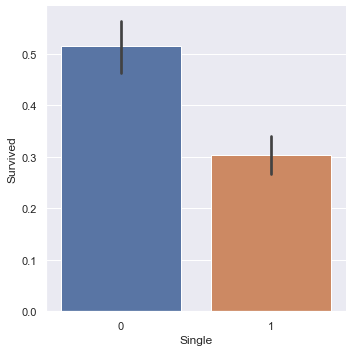

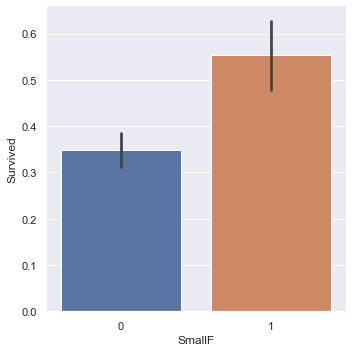

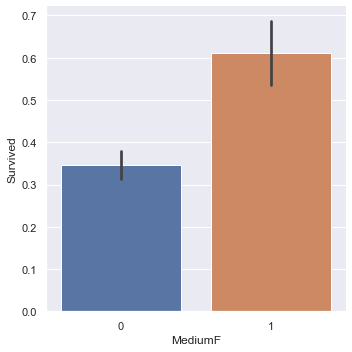

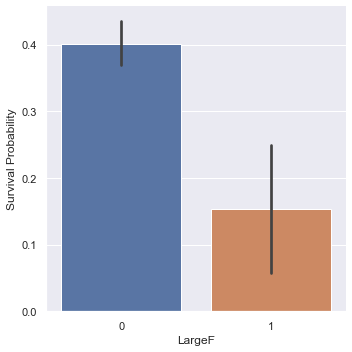

In [51]:
g = sns.factorplot(y='Survived',x='Single',data=df,kind='bar')
g = sns.factorplot(y='Survived',x='SmallF',data=df,kind='bar')
g = sns.factorplot(y='Survived',x='MediumF',data=df,kind='bar')
g = sns.factorplot(y='Survived',x='LargeF',data=df,kind='bar')

g = g.set_ylabels('Survival Probability')

In [52]:
df = pd.get_dummies(df,columns=['Title'])

In [53]:
df = pd.get_dummies(df,columns=['Embarked'],prefix='Em')

In [54]:
df.columns

Index(['Age', 'Cabin', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Ticket', 'FSize', 'Single', 'SmallF', 'MediumF',
       'LargeF', 'Title_0', 'Title_1', 'Title_2', 'Title_3', 'Em_C', 'Em_Q',
       'Em_S'],
      dtype='object')

#### Label Encoding vs One-Hot Encoding

* If categorical features then label encoding

* if non-ordinal relation then use one-hot encoding

#### Cabin

In [55]:
df['Cabin'].head(20)

0      NaN
1      C85
2      NaN
3     C123
4      NaN
5      NaN
6      E46
7      NaN
8      NaN
9      NaN
10      G6
11    C103
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
Name: Cabin, dtype: object

In [56]:
df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df['Cabin']])


In [57]:
df['Cabin'].head(20)

0     X
1     C
2     X
3     C
4     X
5     X
6     E
7     X
8     X
9     X
10    G
11    C
12    X
13    X
14    X
15    X
16    X
17    X
18    X
19    X
Name: Cabin, dtype: object

In [58]:
df['Cabin'].value_counts()

X    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

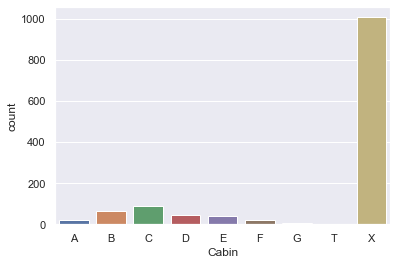

In [59]:
g = sns.countplot(df['Cabin'],order='A B C D E F G T X'.split())

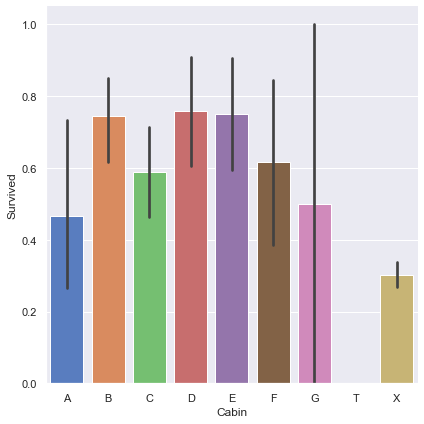

In [60]:
g = sns.factorplot(x='Cabin',y='Survived',data=df,kind='bar',size=6,palette='muted',order='A B C D E F G T X'.split())

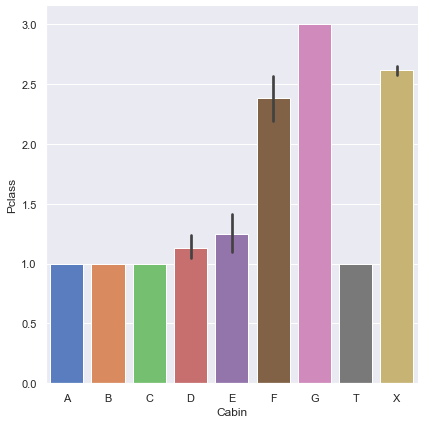

In [61]:
g = sns.factorplot(x='Cabin',y='Pclass',data=df,kind='bar',size=6,palette='muted',order='A B C D E F G T X'.split())

In [62]:
df = pd.get_dummies(df,columns=['Cabin'],prefix='Cabin')

In [63]:
df.columns

Index(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Ticket', 'FSize', 'Single', 'SmallF', 'MediumF', 'LargeF',
       'Title_0', 'Title_1', 'Title_2', 'Title_3', 'Em_C', 'Em_Q', 'Em_S',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_X'],
      dtype='object')

#### Ticket

In [64]:
df['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [65]:
ticket = []


for i in list(df['Ticket']):
    if not i.isdigit():
        ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])
    else:
        ticket.append('X')

df['Ticket'] = ticket

In [66]:
df['Ticket'].head(20)

0         A5
1         PC
2     STONO2
3          X
4          X
5          X
6          X
7          X
8          X
9          X
10        PP
11         X
12        A5
13         X
14         X
15         X
16         X
17         X
18         X
19         X
Name: Ticket, dtype: object

In [67]:
s = 'STON/O2. 3101282'


x = s.replace('.','').replace('/','').strip().split(' ')[0]
x

'STONO2'

In [68]:
df['Ticket'].value_counts()

X          954
PC          92
CA          61
A5          28
SOTONOQ     24
WC          15
STONO       14
SCPARIS     14
A4          10
FCC          9
C            8
SOC          8
STONO2       7
SOPP         7
SCParis      5
SCAH         5
WEP          4
LINE         4
PP           4
SOTONO2      3
FC           3
SCA4         2
PPP          2
SC           2
SWPP         2
SCOW         1
SCA3         1
AQ4          1
STONOQ       1
AS           1
LP           1
SOP          1
A            1
SP           1
CASOTON      1
Fa           1
AQ3          1
Name: Ticket, dtype: int64

In [69]:
df['Sex'] = df['Sex'].map({'male':0,'female':1})

In [70]:
df['Sex'].unique()

array([0, 1])

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 30 columns):
Age            1299 non-null float64
Fare           1299 non-null float64
Parch          1299 non-null int64
PassengerId    1299 non-null int64
Pclass         1299 non-null int64
Sex            1299 non-null int64
SibSp          1299 non-null int64
Survived       881 non-null float64
Ticket         1299 non-null object
FSize          1299 non-null int64
Single         1299 non-null int64
SmallF         1299 non-null int64
MediumF        1299 non-null int64
LargeF         1299 non-null int64
Title_0        1299 non-null uint8
Title_1        1299 non-null uint8
Title_2        1299 non-null uint8
Title_3        1299 non-null uint8
Em_C           1299 non-null uint8
Em_Q           1299 non-null uint8
Em_S           1299 non-null uint8
Cabin_A        1299 non-null uint8
Cabin_B        1299 non-null uint8
Cabin_C        1299 non-null uint8
Cabin_D        1299 non-null uint8
Cabin_E     

In [72]:
df = pd.get_dummies(df,columns=['Ticket'],prefix='Ticket')

In [73]:
df.columns

Index(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'FSize', 'Single', 'SmallF', 'MediumF', 'LargeF', 'Title_0',
       'Title_1', 'Title_2', 'Title_3', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Cabin_X', 'Ticket_A', 'Ticket_A4', 'Ticket_A5',
       'Ticket_AQ3', 'Ticket_AQ4', 'Ticket_AS', 'Ticket_C', 'Ticket_CA',
       'Ticket_CASOTON', 'Ticket_FC', 'Ticket_FCC', 'Ticket_Fa', 'Ticket_LINE',
       'Ticket_LP', 'Ticket_PC', 'Ticket_PP', 'Ticket_PPP', 'Ticket_SC',
       'Ticket_SCA3', 'Ticket_SCA4', 'Ticket_SCAH', 'Ticket_SCOW',
       'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOP',
       'Ticket_SOPP', 'Ticket_SOTONO2', 'Ticket_SOTONOQ', 'Ticket_SP',
       'Ticket_STONO', 'Ticket_STONO2', 'Ticket_STONOQ', 'Ticket_SWPP',
       'Ticket_WC', 'Ticket_WEP', 'Ticket_X'],
      dtype='object')

#### Modeling


In [74]:
train = df[:train_len]
test = df[train_len:]

In [75]:
test.drop('Survived',axis=1,inplace=True)

In [76]:
train['Survived'] = train['Survived'].astype(int)

y_train = train['Survived']

X_train = train.drop('Survived',axis=1)

In [77]:
X_train.shape

(881, 65)

In [78]:
kfold = StratifiedKFold(n_splits=10)

In [79]:
random_state = 42
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))

In [80]:
classifiers

[SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
     verbose=False),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=42, splitter='best')]

In [81]:
cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,X_train,y=y_train,scoring='accuracy',cv=kfold,n_jobs=4))

In [82]:
cv_results

[array([0.61797753, 0.61363636, 0.61363636, 0.61363636, 0.61363636,
        0.61363636, 0.61363636, 0.61363636, 0.61363636, 0.61363636]),
 array([0.50561798, 0.67045455, 0.73863636, 0.78409091, 0.77272727,
        0.79545455, 0.84090909, 0.79545455, 0.78409091, 0.78409091])]

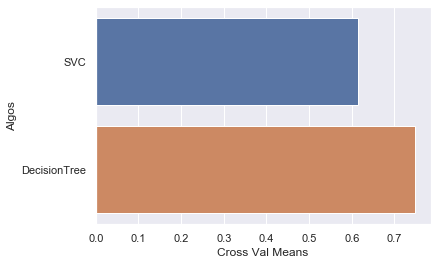

In [83]:
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_results1 = pd.DataFrame({'Cross Val Means': cv_means, 'Cross Val Errors':cv_std,'Algos':['SVC','DecisionTree']})    

g = sns.barplot('Cross Val Means','Algos',data=cv_results1)

In [84]:
cv_results1

,Cross Val Means,Cross Val Errors,Algos
0,0.614070,0.001302,SVC
1,0.747153,0.090828,DecisionTree


In [88]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=42)

param_grid = {'base_estimator__splitter': ['best'], 
              'n_estimators':[1,2], 
              'learning_rate':[0.001,0.01,0.1,1]}

gsAdaDTC = GridSearchCV(adaDTC,param_grid=param_grid,cv=kfold,scoring="accuracy",
                        n_jobs=-1,verbose=10)

gsAdaDTC.fit(X_train,y_train)

ada_best = gsAdaDTC.best_estimator_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1838s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0885s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  65 out of  80 | elapsed:    2.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.3s finished


In [90]:
svc = SVC()

param_grid = {'kernel': ['rbf'], 
              'gamma':[1,10,100,1000], 
              'C':[0.001,0.01,0.1,1]}

gsSVC = GridSearchCV(svc,param_grid=param_grid,cv=kfold,scoring="accuracy",
                        n_jobs=-1,verbose=10)

gsSVC.fit(X_train,y_train)

svc_best = gsSVC.best_estimator_

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0689s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 128 out of 160 | elapsed:    1.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.1s finished


#### Ensemble Modeling

In [91]:
votingC = VotingClassifier(estimators=[('svc',svc_best),('AdaClx',ada_best)])

votingC = votingC.fit(X_train,y_train)

##### Prediction

In [92]:
test_survived = pd.Series(votingC.predict(test),name='Survived')

results = pd.concat([idtest,test_survived],axis=1)

In [93]:
results.to_csv('ensemble_submission.csv',index=False)

In [94]:
pwd

'/Users/vipulgaur/Documents/Training/advanced-ML/25Jul/Ensemble'

# Great Job !